# Lecture 4: Simulation of Kolmogorov Flow

In [1]:
%matplotlib inline 
# plots graphs within the notebook
%config InlineBackend.figure_format='svg' # not sure what this does, may be default images to svg format

from IPython.display import Image

from IPython.core.display import HTML
def header(text):
    raw_html = '<h4>' + str(text) + '</h4>'
    return raw_html

def box(text):
    raw_html = '<div style="border:1px dotted black;padding:2em;">'+str(text)+'</div>'
    return HTML(raw_html)

def nobox(text):
    raw_html = '<p>'+str(text)+'</p>'
    return HTML(raw_html)

def addContent(raw_html):
    global htmlContent
    htmlContent += raw_html
    
class PDF(object):
  def __init__(self, pdf, size=(200,200)):
    self.pdf = pdf
    self.size = size

  def _repr_html_(self):
    return '<iframe src={0} width={1[0]} height={1[1]}></iframe>'.format(self.pdf, self.size)

  def _repr_latex_(self):
    return r'\includegraphics[width=1.0\textwidth]{{{0}}}'.format(self.pdf)

class ListTable(list):
    """ Overridden list class which takes a 2-dimensional list of 
        the form [[1,2,3],[4,5,6]], and renders an HTML Table in 
        IPython Notebook. """
    
    def _repr_html_(self):
        html = ["<table>"]
        for row in self:
            html.append("<tr>")
            
            for col in row:
                html.append("<td>{0}</td>".format(col))
            
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)
    
font = {'family' : 'serif',
        'color'  : 'black',
        'weight' : 'normal',
        'size'   : 18,
        }



<p class='alert alert-success'>
Solve the questions in green blocks. Save the file as ME249-Lecture-4-YOURNAME.ipynb and change YOURNAME in the bottom cell. Send the instructor and the grader the <b>html</b> file not the ipynb file. 
</p>

## Test Function u

In [43]:
import matplotlib.pyplot as plt
import numpy as np

Lx = 2.*np.pi
Ly = 2.*np.pi

Nx = 32
Ny = 64

Reynolds = 10.
nu = 1./Reynolds

dx = Lx / Nx
dy = Ly / Ny

x_n = np.linspace(+dx/2.,Lx-dx/2.,Nx)
y_n = np.linspace(+dy/2.,Ly-dy/2.,Ny)

Yn,Xn = np.meshgrid(y_n,x_n)

u = np.zeros((Nx,Ny),dtype='float64')
v = np.zeros((Nx,Ny),dtype='float64')
p = np.zeros((Nx,Ny),dtype='float64')

F_xx = np.zeros((Nx,Ny),dtype='float64')
F_xy = np.zeros((Nx,Ny),dtype='float64')
F_yy = np.zeros((Nx,Ny),dtype='float64')

def flux_computation(u,v,p,dx,dy,nu):
    nx = u.shape[0]
    ny = u.shape[1]
    
    f_xx = np.zeros((nx,ny),dtype='float64')
    f_xx[0:nx-1,:] = -0.25*(u[1:nx,:]+u[0:nx-1,:])*(u[1:nx,:]+u[0:nx-1,:]) \
                     +2.*nu*(u[1:nx,:]-u[0:nx-1,:])/dx
    f_xx[nx-1,:] = -0.25*(u[0,:]+u[nx-1,:])*(u[0,:]+u[nx-1,:]) \
                   + 2.*nu*(u[0,:]-u[nx-1,:])/dx
    
    f_xy = np.zeros((nx,ny),dtype='float64')
    f_xy[0:nx-1,0:ny-1] = -0.25*(u[0:nx-1,0:ny-1]+u[0:nx-1,1:ny]) \
                               *(v[0:nx-1,0:ny-1]+v[1:nx,0:ny-1]) \
                          +nu*((u[0:nx-1,1:ny]-u[0:nx-1,0:ny-1])/dy\
                              +(v[1:nx,0:ny-1]-v[0:nx-1,0:ny-1])/dx)
    f_xy[nx-1,0:ny-1] = -0.25*(u[nx-1,0:ny-1]+u[nx-1,1:ny]) \
                               *(v[nx-1,0:ny-1]+v[0,0:ny-1]) \
                          +nu*((u[nx-1,1:ny]-u[nx-1,0:ny-1])/dy\
                              +(v[0,0:ny-1]-v[nx-1,0:ny-1])/dx)
    f_xy[0:nx-1,ny-1] = -0.25*(u[0:nx-1,ny-1]+u[0:nx-1,0]) \
                               *(v[0:nx-1,ny-1]+v[1:nx,ny-1]) \
                          +nu*((u[0:nx-1,0]-u[0:nx-1,ny-1])/dy\
                              +(v[1:nx,ny-1]-v[0:nx-1,ny-1])/dx)
    f_xy[nx-1,ny-1] = -0.25*(u[nx-1,ny-1]+u[nx-1,0]) \
                               *(v[nx-1,ny-1]+v[0,ny-1]) \
                          +nu*((u[nx-1,0]-u[nx-1,ny-1])/dy\
                              +(v[0,ny-1]-v[nx-1,ny-1])/dx)
    f_yy = np.zeros((nx,ny),dtype='float64')
    f_yy[0:nx-1,0:ny-1] = -0.25*(v[0:nx-1,0:ny-1]+v[0:nx-1,1:ny]) \
                               *(v[0:nx-1,0:ny-1]+v[0:nx-1,1:ny]) \
                          +2.*nu*(v[0:nx-1,1:ny]-v[0:nx-1,0:ny-1])/dy
    f_yy[0:nx-1,ny-1] = -0.25*(v[0:nx-1,ny-1]+v[0:nx-1,0]) \
                               *(v[0:nx-1,ny-1]+v[0:nx-1,0]) \
                          +2.*nu*(v[0:nx-1,0]-v[0:nx-1,ny-1])/dy
    return f_xx,f_xy,f_yy

def flux_divergence(f_x,f_y,dx,dy):
    nx = f_x.shape[0]
    ny = f_x.shape[1]
    div_x = np.zeros((nx,ny),dtype='float64')
    div_x[1:nx,:] = (f_x[1:nx,:] - f_x[0:nx-1,:])/dx
    div_x[0,:] = (f_x[0,:] - f_x[nx-1,:])/dx
    div_y = np.zeros((nx,ny),dtype='float64')
    div_y[:,1:ny] = (f_y[:,1:ny] - f_y[:,0:ny-1])/dy
    div_y[:,o] = (f_y[:,0] - f_y[:,ny-1])/dy
    return div_x+div_y





<h2> Taylor-Green vortex</h2>

$$
u =f(t)\sin x\cos y,\; v = f(t)\cos x \sin y,\; p = \frac{1}{4}f^2(t)(\cos 2x+\cos 2y)
$$

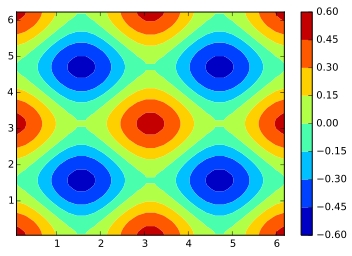

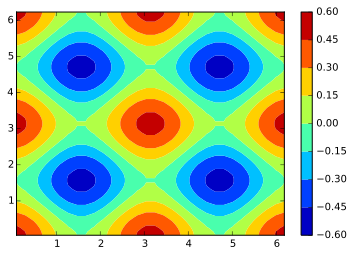

In [52]:


source = np.zeros((Nx,Ny))

p_exact = (np.cos(2.*Xn)+np.cos(2.*Yn))/4.
source = -np.cos(2.*Xn)-np.cos(2.*Yn)
source_hat = np.fft.fft2(source)

kx = Nx*np.fft.fftfreq(Nx)
ky = Ny*np.fft.fftfreq(Ny)

kx2d = np.repeat(kx, Ny)
kx2d.shape = (Nx, Ny)

ky2d = np.repeat(ky, Nx)
ky2d.shape = (Ny, Nx)
ky2d = np.transpose(ky2d)


mk2  = 2.0*(np.cos(2.0*np.pi*kx2d/Nx)-1.0)/(dx*dx)\
      +2.0*(np.cos(2.0*np.pi*ky2d/Ny)-1.0)/(dy*dy) + 1.e-20

p_hat =  source_hat/mk2

p_hat[0,0] = 0.0 + 0.0j
p = np.real(np.fft.ifft2(p_hat))



plt.contourf(Xn,Yn,p_exact)
plt.colorbar()
plt.show()


plt.contourf(Xn,Yn,p)
plt.colorbar()
plt.show()

In [5]:
!ipython nbconvert --to html ME249-Lecture-4-YOURNAME.ipynb

[NbConvertApp] WARNING | pattern u'ME249-Lecture-3-YOURNAME.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--init
    Initialize profile with default config files.  This is equivalent
    to running `ipython profile create <profile>` prior to startup.
--execute
    Execute the notebook prior to export.
--stdout
    Write notebook output to stdout instead of files.
--debug
    set log level to logging.DEBUG (maximize logging output)
--quiet
    set log level to logging.CRITICAL (minimize logging output)
--inplace
    Run nbconvert in place, overwriting the existing notebook (only 
    relevant when converting to notebook format)
--profile=<Unicode> (BaseIPythonApplication.profile)
    Default: u'default'
    The IPython